In [1]:
import sqlalchemy
from secret import *
import pandas as pd
engine = sqlalchemy.create_engine(f'postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}/{POSTGRES_DATABASE}')

with engine.connect() as conn:

    result = conn.execute(sqlalchemy.text('select 1'))

# Lecture 9 - Intro to databases

### Contents:

* DataTypes
* Tables
* Joins
* Python - SQLAlchemy
* SQL + Pandas implementation!



In [2]:
result.fetchall()

[(1,)]

## Why do I need it?

* Peristence of data
* CSVs might not be suitable anymore:
    * No data sanitation
    * Access management
    * Cannot share between clients
    * Parallel writing
    * Speed of writing/reading

* Lookup in the dataset! Always need to load the whole thing

## Relational databases

* optimize storage -> use normalized data - discover relations using joins
* normalization of data - each table contains its specific data and relates to others through keys
* designed on ACID principle - Atomicity, Consistency, Isolation, Durability
* store huge data 
* read it very fast - depending on the design
* Many different applications!
    * Business
    * Web-servers
    * Big data
  
* Protected access with username / password, vpns
* Users have specific permissions! Read/write/delete

## SQL
*Structured Query Language*
* Human (easily) readable
* Different implementations
    * engines: SQLite, MySQL, Oracle, PostgreSQL
* SQL is only a language
* Data are stored in *Tables* 
* Connected via *Relations*
* NoSQL - MongoDB, CouchDB, DynamoDB - they optimize access speed, instead of storage (now storage is cheap), async, scalable and latency optimal
* Distributed databases such as Apache Hive - big data databases (map-reduce) how


### Basic philosophy
![alt text](./img/sql_filosofie.png )


### Database Layers
![sql struktura](./img/sql_struktura.png)


### Data Types
depends on specific application
* numeric
    * INT, INTEGER, REAL, FLOAT, DOUBLE etc.
* strings
    * STRING, TEXT, VARCHAR
* more specialized
    * DATE, TIME etc.


## How to use it? 
* Command-line
* Python drivers
* Programming interface
* GUI Interface - [DBeaver](https://dbeaver.io/)
* Integration with existing software - MS Office, etc

We always connect to the server, to establish a connection. Then use a cursor (client) to send commands and retreive results the DB prepares for us.

### Our database

### Get all records from `prices` table

In [3]:
pd.read_sql_query(
'''
SELECT * FROM prices
''',con=engine)

,date,company,high,low,open,close,volume,adj_close
0,2017-11-13,CVS,74.000000,70.290001,71.180000,71.480003,9874900.0,63.173630
1,2017-11-14,CVS,71.440002,69.910004,71.150002,70.440002,5964000.0,62.254482
2,2017-11-15,CVS,70.379997,69.400002,70.000000,69.800003,5333900.0,61.688839
3,2017-11-16,CVS,71.050003,69.550003,70.099998,70.260002,6447600.0,62.095394
4,2017-11-17,CVS,71.029999,70.000000,70.250000,70.680000,5382200.0,62.466579
...,...,...,...,...,...,...,...,...
3772,2022-11-07,ALGN,184.350006,178.929993,182.800003,181.369995,911000.0,181.369995
3773,2022-11-08,ALGN,185.479996,175.339996,181.399994,180.399994,1412900.0,180.399994
3774,2022-11-09,ALGN,179.720001,174.130005,179.720001,174.580002,1202400.0,174.580002
3775,2022-11-10,ALGN,196.710007,186.500000,186.960007,196.479996,1605100.0,196.479996


### SELECT closing prices from CVS company

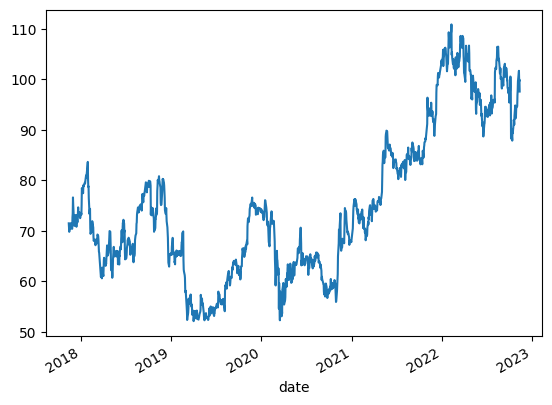

In [4]:
pd.read_sql_query(
'''
SELECT 
    date,
    close 
FROM prices p
WHERE 
    p.company = 'CVS'
''',con=engine, index_col=['date']).close.plot()

### Again we have data types

In [5]:
pd.read_sql_query('''
SELECT
    pg_typeof(date) as date,
    pg_typeof(close) as close
FROM public.prices
limit 1
''',engine)

,date,close
0,timestamp without time zone,double precision


Difference between close and adj_close

In [ ]:
pd.read_sql_query('''
SELECT 
''',engine,index_col=['company','date']).adjustment.unstack('company').plot()

### More complicated queries
#### Number of growth dates and decrease dates

In [8]:
pd.read_sql_query('''
SELECT 
    p.company,
    p.is_growing,
    count(*)
FROM (
    SELECT 
        company,
        date,
        open < close as is_growing
    FROM 
        prices
    ) p
GROUP BY 
    p.company, p.is_growing
ORDER BY 
    company,is_growing
''',engine)

,company,is_growing,count
0,AIZ,False,608
1,AIZ,True,651
2,ALGN,False,620
3,ALGN,True,639
4,CVS,False,629
5,CVS,True,630


compare with:

In [11]:
prices = pd.read_sql_query('''
SELECT * FROM prices
''',engine,index_col=['date','company'])

(prices.close > prices.open).groupby('company').value_counts().unstack(1)

,False,True
company,,
AIZ,608,651
ALGN,620,639
CVS,629,630


SELECT total returns

In [12]:
pd.read_sql_query('''
select distinct company,
    (array_agg(close order by date asc))[1] as start,
    (array_agg(date order by date asc))[1] as start_date,
    (array_agg(close order by date desc))[1] as end,
    (array_agg(date order by date desc))[1] as end_date
    from prices
group by company;
''',engine)

,company,start,start_date,end,end_date
0,AIZ,98.699997,2017-11-13,128.149994,2022-11-11
1,ALGN,253.729996,2017-11-13,218.979996,2022-11-11
2,CVS,71.480003,2017-11-13,97.550003,2022-11-11


compare with

In [13]:
prices.groupby('company').apply(lambda g: pd.Series({
    'start_date':g.index[0][0],
    'start':g.close.iloc[0],
    'end_date':g.index[-1][0],
    'end':g.close.iloc[-1]
}))

,start_date,start,end_date,end
company,,,,
AIZ,2017-11-13,98.699997,2022-11-11,128.149994
ALGN,2017-11-13,253.729996,2022-11-11,218.979996
CVS,2017-11-13,71.480003,2022-11-11,97.550003


### Primary keys and indexation
* An "index" uniquely defining row in a table
* Often integer, but not necessarily
* can be created for multiple columns
* Should be be created manually
* Optimized search - comparison etc on primary keys column


```sql
CREATE TABLE CUSTOMERS(
   ID   INT              NOT NULL,
   NAME VARCHAR (20)     NOT NULL,
   AGE  INT              NOT NULL,
   ADDRESS  CHAR (25) ,
   SALARY   DECIMAL (18, 2),        
   PRIMARY KEY (ID, NAME)
);

```

### Foreign keys



### JOINS 

* connecting tables - relations!

<img src='https://learnsql.com/blog/learn-and-practice-sql-joins/learn-and-practice-sql-joins_huae29a694adef4ea68af92a62b77262a6_190891_968x550_fill_box_center_2.png' width="800" />


In [6]:
pd.read_sql_query('''
SELECT * FROM companies
''',engine)

,symbol,security,gics_sector,hq,included,founded
0,MMM,3M,Industrials,"Saint Paul, Minnesota",09.08.1976,1902
1,AOS,A. O. Smith,Industrials,"Milwaukee, Wisconsin",26.07.2017,1916
2,ABT,Abbott,Health Care,"North Chicago, Illinois",31.03.1964,1888
3,ABBV,AbbVie,Health Care,"North Chicago, Illinois",31.12.2012,2013 (1888)
4,ABMD,Abiomed,Health Care,"Danvers, Massachusetts",31.05.2018,1981
...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,"Louisville, Kentucky",06.10.1997,1997
499,ZBRA,Zebra Technologies,Information Technology,"Lincolnshire, Illinois",23.12.2019,1969
500,ZBH,Zimmer Biomet,Health Care,"Warsaw, Indiana",07.08.2001,1927
501,ZION,Zions Bancorporation,Financials,"Salt Lake City, Utah",22.06.2001,1873


In [7]:
pd.read_sql_query('''
SELECT 
    company,
    close
FROM 
    prices 
WHERE date = '2022-11-11'
''',engine)

,company,close
0,CVS,97.550003
1,AIZ,128.149994
2,ALGN,218.979996


In [8]:
pd.read_sql_query('''
SELECT
    c.symbol,
    c.hq,
    p.last_close
FROM companies c
LEFT JOIN (
    SELECT 
        company,
        close as last_close
    FROM 
        prices 
    WHERE date = '2022-11-11'
) p ON p.company = c.symbol
''',engine)

,symbol,hq,last_close
0,MMM,"Saint Paul, Minnesota",NaN
1,AOS,"Milwaukee, Wisconsin",NaN
2,ABT,"North Chicago, Illinois",NaN
3,ABBV,"North Chicago, Illinois",NaN
4,ABMD,"Danvers, Massachusetts",NaN
...,...,...,...
498,YUM,"Louisville, Kentucky",NaN
499,ZBRA,"Lincolnshire, Illinois",NaN
500,ZBH,"Warsaw, Indiana",NaN
501,ZION,"Salt Lake City, Utah",NaN


In [9]:
pd.read_sql_query('''
SELECT
    c.symbol,
    c.hq,
    p.last_close
FROM companies c
INNER JOIN (
    SELECT 
        company,
        close as last_close
    FROM 
        prices 
    WHERE date = '2022-11-11'
) p ON p.company = c.symbol
''',engine)

,symbol,hq,last_close
0,ALGN,"Tempe, Arizona",218.979996
1,AIZ,"New York City, New York",128.149994
2,CVS,"Woonsocket, Rhode Island",97.550003


In [ ]:
pd.read_sql_query('''
SELECT
    c.symbol,
    c.hq,
    p.last_close
FROM companies c
RIGHT JOIN (
    SELECT 
        company,
        close as last_close
    FROM 
        prices 
    WHERE date = '2022-11-11'
) p ON p.company = c.symbol
''',engine)

In [ ]:
pd.read_sql_query('''
SELECT
    c.symbol,
    c.hq,
    p.last_close
FROM companies c
FULL OUTER JOIN (
    SELECT 
        company,
        close as last_close
    FROM 
        prices 
    WHERE date = '2022-11-11'
) p ON p.company = c.symbol
''',engine)

<img src='./img/sql_order.png' width="1800" />


### Extract, transform, load processes (ETL)

* At the core of any business intelligence solution

* Seemingly trivial, yet complex - especially for near real time solutions in finance or traffic

1. `Extract` - get the data (probably from API or database)
    * regularity
    * checkíng for consistency?
    * backward corrections?
2. `Transform`
    * data cleaning
    * unpacking jsons into tables
3. `Load` - put it where you need it
    * most likely a database

### SQL + Python = sqlalchemy
* Object Relational Mapper (ORM) tool
* Data are most often generated or extracted in object logic, but we need to save it in tables
* sqlalchemy is a middle man between the two
* built-in many different SQL dialects

#### Engine
* Instructions for connection - database server and login information, driver and dialect
* "connection string" - see above


#### Connection
* active tunnel to the database
* Make sure to close the connection you open

In [ ]:
with engine.connect() as conn:

    result = conn.execute(sqlalchemy.text('''
    SELECT * FROM prices'''))
pd.DataFrame(result.fetchall())

### Crucial commands

* CREATE TABLE
* INSERT INTO ... VALUES ....
* SELECT * FROM ...


# SANITIZE YOUR INPUTS

<Img src='https://imgs.xkcd.com/comics/exploits_of_a_mom.png' />